In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch import Tensor
from typing import Optional, Tuple

In [2]:
class Swish(nn.Module):
    """
    Swish is a smooth, non-monotonic function that consistently matches or outperforms ReLU on deep networks applied
    to a variety of challenging domains such as Image classification and Machine translation.
    """
    def __init__(self):
        super(Swish, self).__init__()
    
    def forward(self, inputs: Tensor) -> Tensor:
        return inputs * inputs.sigmoid()


class GLU(nn.Module):
    """
    The gating mechanism is called Gated Linear Units (GLU), which was first introduced for natural language processing
    in the paper “Language Modeling with Gated Convolutional Networks”
    """
    def __init__(self, dim: int) -> None:
        super(GLU, self).__init__()
        self.dim = dim

    def forward(self, inputs: Tensor) -> Tensor:
        outputs, gate = inputs.chunk(2, dim=self.dim)
        return outputs * gate.sigmoid()

In [3]:
class ResidualConnectionModule(nn.Module):
    """
    Residual Connection Module.
    outputs = (module(inputs) x module_factor + inputs x input_factor)
    """
    def __init__(self, module: nn.Module, module_factor: float = 1.0, input_factor: float = 1.0):
        super(ResidualConnectionModule, self).__init__()
        self.module = module
        self.module_factor = module_factor
        self.input_factor = input_factor

    def forward(self, inputs: Tensor) -> Tensor:
        return (self.module(inputs) * self.module_factor) + (inputs * self.input_factor)

In [4]:
class Linear(nn.Module):
    """
    Wrapper class of torch.nn.Linear
    Weight initialize by xavier initialization and bias initialize to zeros.
    """
    def __init__(self, in_features: int, out_features: int, bias: bool = True) -> None:
        super(Linear, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        init.xavier_uniform_(self.linear.weight)
        if bias:
            init.zeros_(self.linear.bias)

    def forward(self, x: Tensor) -> Tensor:
        return self.linear(x)

In [5]:
class View(nn.Module):
    """ Wrapper class of torch.view() for Sequential module. """
    def __init__(self, shape: tuple, contiguous: bool = False):
        super(View, self).__init__()
        self.shape = shape
        self.contiguous = contiguous

    def forward(self, x: Tensor) -> Tensor:
        if self.contiguous:
            x = x.contiguous()

        return x.view(*self.shape)

In [6]:
class Transpose(nn.Module):
    """ Wrapper class of torch.transpose() for Sequential module. """
    def __init__(self, shape: tuple):
        super(Transpose, self).__init__()
        self.shape = shape

    def forward(self, x: Tensor) -> Tensor:
        return x.transpose(*self.shape)

In [7]:
class PositionalEncoding(nn.Module):
    """
    Positional Encoding proposed in "Attention Is All You Need".
    Since transformer contains no recurrence and no convolution, in order for the model to make
    use of the order of the sequence, we must add some positional information.
    "Attention Is All You Need" use sine and cosine functions of different frequencies:
        PE_(pos, 2i)    =  sin(pos / power(10000, 2i / d_model))
        PE_(pos, 2i+1)  =  cos(pos / power(10000, 2i / d_model))
    """
    def __init__(self, d_model: int = 512, max_len: int = 10000) -> None:
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model, requires_grad=False)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, length: int) -> Tensor:
        return self.pe[:, :length]

In [8]:
class RelativeMultiHeadAttention(nn.Module):
    """
    Multi-head attention with relative positional encoding.
    This concept was proposed in the "Transformer-XL: Attentive Language Models Beyond a Fixed-Length Context"
    Args:
        d_model (int): The dimension of model
        num_heads (int): The number of attention heads.
        dropout_p (float): probability of dropout
    Inputs: query, key, value, pos_embedding, mask
        - **query** (batch, time, dim): Tensor containing query vector
        - **key** (batch, time, dim): Tensor containing key vector
        - **value** (batch, time, dim): Tensor containing value vector
        - **pos_embedding** (batch, time, dim): Positional embedding tensor
        - **mask** (batch, 1, time2) or (batch, time1, time2): Tensor containing indices to be masked
    Returns:
        - **outputs**: Tensor produces by relative multi head attention module.
    """
    def __init__(
            self,
            d_model: int = 512,
            num_heads: int = 16,
            dropout_p: float = 0.1,
    ):
        super(RelativeMultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model % num_heads should be zero."
        self.d_model = d_model
        self.d_head = int(d_model / num_heads)
        self.num_heads = num_heads
        self.sqrt_dim = math.sqrt(d_model)

        self.query_proj = Linear(d_model, d_model)
        self.key_proj = Linear(d_model, d_model)
        self.value_proj = Linear(d_model, d_model)
        self.pos_proj = Linear(d_model, d_model, bias=False)

        self.dropout = nn.Dropout(p=dropout_p)
        self.u_bias = nn.Parameter(torch.Tensor(self.num_heads, self.d_head))
        self.v_bias = nn.Parameter(torch.Tensor(self.num_heads, self.d_head))
        torch.nn.init.xavier_uniform_(self.u_bias)
        torch.nn.init.xavier_uniform_(self.v_bias)

        self.out_proj = Linear(d_model, d_model)

    def forward(
            self,
            query: Tensor,
            key: Tensor,
            value: Tensor,
            pos_embedding: Tensor,
            mask: Optional[Tensor] = None,
    ) -> Tensor:
        batch_size = value.size(0)

        query = self.query_proj(query).view(batch_size, -1, self.num_heads, self.d_head)
        key = self.key_proj(key).view(batch_size, -1, self.num_heads, self.d_head).permute(0, 2, 1, 3)
        value = self.value_proj(value).view(batch_size, -1, self.num_heads, self.d_head).permute(0, 2, 1, 3)
        pos_embedding = self.pos_proj(pos_embedding).view(batch_size, -1, self.num_heads, self.d_head)

        content_score = torch.matmul((query + self.u_bias).transpose(1, 2), key.transpose(2, 3))
        pos_score = torch.matmul((query + self.v_bias).transpose(1, 2), pos_embedding.permute(0, 2, 3, 1))
        pos_score = self._relative_shift(pos_score)

        score = (content_score + pos_score) / self.sqrt_dim

        if mask is not None:
            mask = mask.unsqueeze(1)
            score.masked_fill_(mask, -1e9)

        attn = F.softmax(score, -1)
        attn = self.dropout(attn)

        context = torch.matmul(attn, value).transpose(1, 2)
        context = context.contiguous().view(batch_size, -1, self.d_model)

        return self.out_proj(context)

    def _relative_shift(self, pos_score: Tensor) -> Tensor:
        batch_size, num_heads, seq_length1, seq_length2 = pos_score.size()
        zeros = pos_score.new_zeros(batch_size, num_heads, seq_length1, 1)
        padded_pos_score = torch.cat([zeros, pos_score], dim=-1)

        padded_pos_score = padded_pos_score.view(batch_size, num_heads, seq_length2 + 1, seq_length1)
        pos_score = padded_pos_score[:, :, 1:].view_as(pos_score)

        return pos_score

In [9]:
class MultiHeadedSelfAttentionModule(nn.Module):
    """
    Conformer employ multi-headed self-attention (MHSA) while integrating an important technique from Transformer-XL,
    the relative sinusoidal positional encoding scheme. The relative positional encoding allows the self-attention
    module to generalize better on different input length and the resulting encoder is more robust to the variance of
    the utterance length. Conformer use prenorm residual units with dropout which helps training
    and regularizing deeper models.
    Args:
        d_model (int): The dimension of model
        num_heads (int): The number of attention heads.
        dropout_p (float): probability of dropout
    Inputs: inputs, mask
        - **inputs** (batch, time, dim): Tensor containing input vector
        - **mask** (batch, 1, time2) or (batch, time1, time2): Tensor containing indices to be masked
    Returns:
        - **outputs** (batch, time, dim): Tensor produces by relative multi headed self attention module.
    """
    def __init__(self, d_model: int, num_heads: int, dropout_p: float = 0.1):
        super(MultiHeadedSelfAttentionModule, self).__init__()
        self.positional_encoding = PositionalEncoding(d_model)
        self.layer_norm = nn.LayerNorm(d_model)
        self.attention = RelativeMultiHeadAttention(d_model, num_heads, dropout_p)
        self.dropout = nn.Dropout(p=dropout_p)

    def forward(self, inputs: Tensor, mask: Optional[Tensor] = None):
        batch_size, seq_length, _ = inputs.size()
        pos_embedding = self.positional_encoding(seq_length)
        pos_embedding = pos_embedding.repeat(batch_size, 1, 1)

        inputs = self.layer_norm(inputs)
        outputs = self.attention(inputs, inputs, inputs, pos_embedding=pos_embedding, mask=mask)

        return self.dropout(outputs)

In [10]:
class DepthwiseConv1d(nn.Module):
    """
    When groups == in_channels and out_channels == K * in_channels, where K is a positive integer,
    this operation is termed in literature as depthwise convolution.
    Args:
        in_channels (int): Number of channels in the input
        out_channels (int): Number of channels produced by the convolution
        kernel_size (int or tuple): Size of the convolving kernel
        stride (int, optional): Stride of the convolution. Default: 1
        padding (int or tuple, optional): Zero-padding added to both sides of the input. Default: 0
        bias (bool, optional): If True, adds a learnable bias to the output. Default: True
    Inputs: inputs
        - **inputs** (batch, in_channels, time): Tensor containing input vector
    Returns: outputs
        - **outputs** (batch, out_channels, time): Tensor produces by depthwise 1-D convolution.
    """
    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            kernel_size: int,
            stride: int = 1,
            padding: int = 0,
            bias: bool = False,
    ) -> None:
        super(DepthwiseConv1d, self).__init__()
        assert out_channels % in_channels == 0, "out_channels should be constant multiple of in_channels"
        self.conv = nn.Conv1d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            groups=in_channels,
            stride=stride,
            padding=padding,
            bias=bias,
        )

    def forward(self, inputs: Tensor) -> Tensor:
        return self.conv(inputs)

In [11]:
class PointwiseConv1d(nn.Module):
    """
    When kernel size == 1 conv1d, this operation is termed in literature as pointwise convolution.
    This operation often used to match dimensions.
    Args:
        in_channels (int): Number of channels in the input
        out_channels (int): Number of channels produced by the convolution
        stride (int, optional): Stride of the convolution. Default: 1
        padding (int or tuple, optional): Zero-padding added to both sides of the input. Default: 0
        bias (bool, optional): If True, adds a learnable bias to the output. Default: True
    Inputs: inputs
        - **inputs** (batch, in_channels, time): Tensor containing input vector
    Returns: outputs
        - **outputs** (batch, out_channels, time): Tensor produces by pointwise 1-D convolution.
    """
    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            stride: int = 1,
            padding: int = 0,
            bias: bool = True,
    ) -> None:
        super(PointwiseConv1d, self).__init__()
        self.conv = nn.Conv1d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=1,
            stride=stride,
            padding=padding,
            bias=bias,
        )

    def forward(self, inputs: Tensor) -> Tensor:
        return self.conv(inputs)


In [12]:
class ConformerConvModule(nn.Module):
    """
    Conformer convolution module starts with a pointwise convolution and a gated linear unit (GLU).
    This is followed by a single 1-D depthwise convolution layer. Batchnorm is  deployed just after the convolution
    to aid training deep models.
    Args:
        in_channels (int): Number of channels in the input
        kernel_size (int or tuple, optional): Size of the convolving kernel Default: 31
        dropout_p (float, optional): probability of dropout
    Inputs: inputs
        inputs (batch, time, dim): Tensor contains input sequences
    Outputs: outputs
        outputs (batch, time, dim): Tensor produces by conformer convolution module.
    """
    def __init__(
            self,
            in_channels: int,
            kernel_size: int = 31,
            expansion_factor: int = 2,
            dropout_p: float = 0.1,
    ) -> None:
        super(ConformerConvModule, self).__init__()
        assert (kernel_size - 1) % 2 == 0, "kernel_size should be a odd number for 'SAME' padding"
        assert expansion_factor == 2, "Currently, Only Supports expansion_factor 2"

        self.sequential = nn.Sequential(
            nn.LayerNorm(in_channels),
            Transpose(shape=(1, 2)),
            PointwiseConv1d(in_channels, in_channels * expansion_factor, stride=1, padding=0, bias=True),
            GLU(dim=1),
            DepthwiseConv1d(in_channels, in_channels, kernel_size, stride=1, padding=(kernel_size - 1) // 2),
            nn.BatchNorm1d(in_channels),
            Swish(),
            PointwiseConv1d(in_channels, in_channels, stride=1, padding=0, bias=True),
            nn.Dropout(p=dropout_p),
        )

    def forward(self, inputs: Tensor) -> Tensor:
        return self.sequential(inputs).transpose(1, 2)

In [13]:
class Conv2dSubampling(nn.Module):
    """
    Convolutional 2D subsampling (to 1/4 length)
    Args:
        in_channels (int): Number of channels in the input image
        out_channels (int): Number of channels produced by the convolution
    Inputs: inputs
        - **inputs** (batch, time, dim): Tensor containing sequence of inputs
    Returns: outputs, output_lengths
        - **outputs** (batch, time, dim): Tensor produced by the convolution
        - **output_lengths** (batch): list of sequence output lengths
    """
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super(Conv2dSubampling, self).__init__()
        self.sequential = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1),
            nn.ReLU(),
        )

    def forward(self, inputs: Tensor, input_lengths: Tensor) -> Tuple[Tensor, Tensor]:
        outputs = self.sequential(inputs.unsqueeze(1))
        batch_size, channels, subsampled_lengths, sumsampled_dim = outputs.size()

        outputs = outputs.permute(0, 2, 1, 3)
        outputs = outputs.contiguous().view(batch_size, subsampled_lengths, channels * sumsampled_dim)

        output_lengths = input_lengths >> 2
        output_lengths -= 1

        return outputs, output_lengths

In [14]:
class FeedForwardModule(nn.Module):
    """
    Conformer Feed Forward Module follow pre-norm residual units and apply layer normalization within the residual unit
    and on the input before the first linear layer. This module also apply Swish activation and dropout, which helps
    regularizing the network.
    Args:
        encoder_dim (int): Dimension of conformer encoder
        expansion_factor (int): Expansion factor of feed forward module.
        dropout_p (float): Ratio of dropout
    Inputs: inputs
        - **inputs** (batch, time, dim): Tensor contains input sequences
    Outputs: outputs
        - **outputs** (batch, time, dim): Tensor produces by feed forward module.
    """
    def __init__(
            self,
            encoder_dim: int = 512,
            expansion_factor: int = 4,
            dropout_p: float = 0.1,
    ) -> None:
        super(FeedForwardModule, self).__init__()
        self.sequential = nn.Sequential(
            nn.LayerNorm(encoder_dim),
            Linear(encoder_dim, encoder_dim * expansion_factor, bias=True),
            Swish(),
            nn.Dropout(p=dropout_p),
            Linear(encoder_dim * expansion_factor, encoder_dim, bias=True),
            nn.Dropout(p=dropout_p),
        )

    def forward(self, inputs: Tensor) -> Tensor:
        return self.sequential(inputs)

In [15]:
class ConformerBlock(nn.Module):
    """
    Conformer block contains two Feed Forward modules sandwiching the Multi-Headed Self-Attention module
    and the Convolution module. This sandwich structure is inspired by Macaron-Net, which proposes replacing
    the original feed-forward layer in the Transformer block into two half-step feed-forward layers,
    one before the attention layer and one after.
    Args:
        encoder_dim (int, optional): Dimension of conformer encoder
        num_attention_heads (int, optional): Number of attention heads
        feed_forward_expansion_factor (int, optional): Expansion factor of feed forward module
        conv_expansion_factor (int, optional): Expansion factor of conformer convolution module
        feed_forward_dropout_p (float, optional): Probability of feed forward module dropout
        attention_dropout_p (float, optional): Probability of attention module dropout
        conv_dropout_p (float, optional): Probability of conformer convolution module dropout
        conv_kernel_size (int or tuple, optional): Size of the convolving kernel
        half_step_residual (bool): Flag indication whether to use half step residual or not
    Inputs: inputs
        - **inputs** (batch, time, dim): Tensor containing input vector
    Returns: outputs
        - **outputs** (batch, time, dim): Tensor produces by conformer block.
    """
    def __init__(
            self,
            encoder_dim: int = 512,
            num_attention_heads: int = 8,
            feed_forward_expansion_factor: int = 4,
            conv_expansion_factor: int = 2,
            feed_forward_dropout_p: float = 0.1,
            attention_dropout_p: float = 0.1,
            conv_dropout_p: float = 0.1,
            conv_kernel_size: int = 31,
            half_step_residual: bool = True,
    ):
        super(ConformerBlock, self).__init__()
        if half_step_residual:
            self.feed_forward_residual_factor = 0.5
        else:
            self.feed_forward_residual_factor = 1

        self.sequential = nn.Sequential(
            ResidualConnectionModule(
                module=FeedForwardModule(
                    encoder_dim=encoder_dim,
                    expansion_factor=feed_forward_expansion_factor,
                    dropout_p=feed_forward_dropout_p,
                ),
                module_factor=self.feed_forward_residual_factor,
            ),
            ResidualConnectionModule(
                module=MultiHeadedSelfAttentionModule(
                    d_model=encoder_dim,
                    num_heads=num_attention_heads,
                    dropout_p=attention_dropout_p,
                ),
            ),
            ResidualConnectionModule(
                module=ConformerConvModule(
                    in_channels=encoder_dim,
                    kernel_size=conv_kernel_size,
                    expansion_factor=conv_expansion_factor,
                    dropout_p=conv_dropout_p,
                ),
            ),
            ResidualConnectionModule(
                module=FeedForwardModule(
                    encoder_dim=encoder_dim,
                    expansion_factor=feed_forward_expansion_factor,
                    dropout_p=feed_forward_dropout_p,
                ),
                module_factor=self.feed_forward_residual_factor,
            ),
            nn.LayerNorm(encoder_dim),
        )

    def forward(self, inputs: Tensor) -> Tensor:
        return self.sequential(inputs)

In [16]:
class ConformerEncoder(nn.Module):
    """
    Conformer encoder first processes the input with a convolution subsampling layer and then
    with a number of conformer blocks.
    Args:
        input_dim (int, optional): Dimension of input vector
        encoder_dim (int, optional): Dimension of conformer encoder
        num_layers (int, optional): Number of conformer blocks
        num_attention_heads (int, optional): Number of attention heads
        feed_forward_expansion_factor (int, optional): Expansion factor of feed forward module
        conv_expansion_factor (int, optional): Expansion factor of conformer convolution module
        feed_forward_dropout_p (float, optional): Probability of feed forward module dropout
        attention_dropout_p (float, optional): Probability of attention module dropout
        conv_dropout_p (float, optional): Probability of conformer convolution module dropout
        conv_kernel_size (int or tuple, optional): Size of the convolving kernel
        half_step_residual (bool): Flag indication whether to use half step residual or not
    Inputs: inputs, input_lengths
        - **inputs** (batch, time, dim): Tensor containing input vector
        - **input_lengths** (batch): list of sequence input lengths
    Returns: outputs, output_lengths
        - **outputs** (batch, out_channels, time): Tensor produces by conformer encoder.
        - **output_lengths** (batch): list of sequence output lengths
    """
    def __init__(
            self,
            input_dim: int = 80,
            encoder_dim: int = 512,
            num_layers: int = 17,
            num_attention_heads: int = 8,
            feed_forward_expansion_factor: int = 4,
            conv_expansion_factor: int = 2,
            input_dropout_p: float = 0.1,
            feed_forward_dropout_p: float = 0.1,
            attention_dropout_p: float = 0.1,
            conv_dropout_p: float = 0.1,
            conv_kernel_size: int = 31,
            half_step_residual: bool = True,
    ):
        super(ConformerEncoder, self).__init__()
        self.conv_subsample = Conv2dSubampling(in_channels=1, out_channels=encoder_dim)
        self.input_projection = nn.Sequential(
            Linear(encoder_dim * (((input_dim - 3) // 1 + 1 - 3) // 1 + 1), encoder_dim),
            nn.Dropout(p=input_dropout_p),
        )
        self.layers = nn.ModuleList([ConformerBlock(
            encoder_dim=encoder_dim,
            num_attention_heads=num_attention_heads,
            feed_forward_expansion_factor=feed_forward_expansion_factor,
            conv_expansion_factor=conv_expansion_factor,
            feed_forward_dropout_p=feed_forward_dropout_p,
            attention_dropout_p=attention_dropout_p,
            conv_dropout_p=conv_dropout_p,
            conv_kernel_size=conv_kernel_size,
            half_step_residual=half_step_residual,
        ) for _ in range(num_layers)])

    def count_parameters(self) -> int:
        """ Count parameters of encoder """
        return sum([p.numel() for p in self.parameters()])

    def update_dropout(self, dropout_p: float) -> None:
        """ Update dropout probability of encoder """
        for name, child in self.named_children():
            if isinstance(child, nn.Dropout):
                child.p = dropout_p

    def forward(self, inputs: Tensor, input_lengths: Tensor) -> Tuple[Tensor, Tensor]:
        """
        Forward propagate a `inputs` for  encoder training.
        Args:
            inputs (torch.FloatTensor): A input sequence passed to encoder. Typically for inputs this will be a padded
                `FloatTensor` of size ``(batch, seq_length, dimension)``.
            input_lengths (torch.LongTensor): The length of input tensor. ``(batch)``
        Returns:
            (Tensor, Tensor)
            * outputs (torch.FloatTensor): A output sequence of encoder. `FloatTensor` of size
                ``(batch, seq_length, dimension)``
            * output_lengths (torch.LongTensor): The length of output tensor. ``(batch)``
        """
        outputs, output_lengths = self.conv_subsample(inputs, input_lengths)
        outputs = self.input_projection(outputs)

        for layer in self.layers:
            outputs = layer(outputs)

        return outputs, output_lengths

In [17]:
class Conformer(nn.Module):
    """
    Conformer: Convolution-augmented Transformer for Speech Recognition
    The paper used a one-lstm Transducer decoder, currently still only implemented
    the conformer encoder shown in the paper.
    Args:
        num_classes (int): Number of classification classes
        input_dim (int, optional): Dimension of input vector
        encoder_dim (int, optional): Dimension of conformer encoder
        num_encoder_layers (int, optional): Number of conformer blocks
        num_attention_heads (int, optional): Number of attention heads
        feed_forward_expansion_factor (int, optional): Expansion factor of feed forward module
        conv_expansion_factor (int, optional): Expansion factor of conformer convolution module
        feed_forward_dropout_p (float, optional): Probability of feed forward module dropout
        attention_dropout_p (float, optional): Probability of attention module dropout
        conv_dropout_p (float, optional): Probability of conformer convolution module dropout
        conv_kernel_size (int or tuple, optional): Size of the convolving kernel
        half_step_residual (bool): Flag indication whether to use half step residual or not
    Inputs: inputs, input_lengths
        - **inputs** (batch, time, dim): Tensor containing input vector
        - **input_lengths** (batch): list of sequence input lengths
    Returns: outputs, output_lengths
        - **outputs** (batch, out_channels, time): Tensor produces by conformer.
        - **output_lengths** (batch): list of sequence output lengths
    """
    def __init__(
            self,
            num_classes: int,
            input_dim: int = 80,
            encoder_dim: int = 512,
            num_encoder_layers: int = 17,
            num_attention_heads: int = 8,
            feed_forward_expansion_factor: int = 4,
            conv_expansion_factor: int = 2,
            input_dropout_p: float = 0.1,
            feed_forward_dropout_p: float = 0.1,
            attention_dropout_p: float = 0.1,
            conv_dropout_p: float = 0.1,
            conv_kernel_size: int = 31,
            half_step_residual: bool = True,
    ) -> None:
        super(Conformer, self).__init__()
        self.encoder = ConformerEncoder(
            input_dim=input_dim,
            encoder_dim=encoder_dim,
            num_layers=num_encoder_layers,
            num_attention_heads=num_attention_heads,
            feed_forward_expansion_factor=feed_forward_expansion_factor,
            conv_expansion_factor=conv_expansion_factor,
            input_dropout_p=input_dropout_p,
            feed_forward_dropout_p=feed_forward_dropout_p,
            attention_dropout_p=attention_dropout_p,
            conv_dropout_p=conv_dropout_p,
            conv_kernel_size=conv_kernel_size,
            half_step_residual=half_step_residual,
        )
        self.fc = Linear(encoder_dim, num_classes, bias=False)
        self.W = nn.Linear(num_classes, 1)

    def count_parameters(self) -> int:
        """ Count parameters of encoder """
        return self.encoder.count_parameters()

    def update_dropout(self, dropout_p) -> None:
        """ Update dropout probability of model """
        self.encoder.update_dropout(dropout_p)

    def forward(self, inputs: Tensor, input_lengths: Tensor) -> Tuple[Tensor, Tensor]:
        """
        Forward propagate a `inputs` and `targets` pair for training.
        Args:
            inputs (torch.FloatTensor): A input sequence passed to encoder. Typically for inputs this will be a padded
                `FloatTensor` of size ``(batch, seq_length, dimension)``.
            input_lengths (torch.LongTensor): The length of input tensor. ``(batch)``
        Returns:
            * predictions (torch.FloatTensor): Result of model predictions.
        """
        encoder_outputs, encoder_output_lengths = self.encoder(inputs, input_lengths)
        outputs = self.fc(encoder_outputs)
        outputs = nn.functional.log_softmax(outputs, dim=-1)
        
        outputs = self.W(torch.sum(outputs,dim=1)/outputs.size(1))
        
        return outputs, encoder_output_lengths

In [18]:
model = Conformer(
    num_classes=10,  # Adjust this based on your specific task
    input_dim=22,
    encoder_dim=64,  # You may need to adjust this for your specific task
    num_encoder_layers=2,  # You may need to adjust this for your specific task
    num_attention_heads=2,
    feed_forward_expansion_factor=4,
    conv_expansion_factor=2,
    input_dropout_p=0,
    feed_forward_dropout_p=0,
    attention_dropout_p=0,
    conv_dropout_p=0,
    conv_kernel_size=3,  # Adjust this based on your input dimension and task
    half_step_residual=True
)

In [19]:
inputs = torch.randn(5, 20, 22)
input_lengths = torch.tensor([20, 20, 20, 20, 20])  # Assuming all input sequences have the same length

# Forward pass through the model
outputs, output_lengths = model(inputs, input_lengths)
print(outputs.shape) 
print(outputs)

torch.Size([5, 1])
tensor([[0.4695],
        [0.3122],
        [0.5816],
        [0.3702],
        [0.4882]], grad_fn=<AddmmBackward0>)


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [21]:
column_names = ['date','AOAL','AOAR','PITCH','W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE','TMAX','FS']

input=pd.read_excel('D:\\研究生毕设\\practice\\QAR_xunlian.xlsx',names=column_names)

In [22]:
feature_names = ['W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE']

df=input[feature_names]

In [23]:
df_for_training=df[feature_names].astype(float)

In [24]:
df_for_training.shape

(11524, 22)

In [25]:
scaler=MinMaxScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

In [26]:
trainX=[]
trainY=[]

In [27]:
n_future=1
n_past=20

In [28]:
for i in range(n_past,len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i:i+n_future,21])

In [29]:
trainX,trainY=np.array(trainX),np.array(trainY)
print('trainX shape=={}.'.format(trainX.shape))
print('trainY shape=={}.'.format(trainY.shape))

trainX shape==(11504, 20, 22).
trainY shape==(11504, 1).


In [30]:
trainX_copy,trainY_copy=trainX.copy(),trainY.copy()

In [31]:
def random_shuffle(data,label):
    randnum = np.random.randint(0, len(label))
    np.random.seed(randnum)
    np.random.shuffle(data)
    np.random.seed(randnum)
    np.random.shuffle(label)
    return data,label

In [32]:
data,label=random_shuffle(trainX,trainY)

In [33]:
def standardization(data):
    mu = np.min(data)
    sigma = np.max(data)-np.min(data)
    return (data - mu) / sigma

In [34]:
for j in range(0,data.shape[2]):
    data[:,:,j]=standardization(data[:,:,j])

In [35]:
label=standardization(label)

In [36]:
# Create a DataLoader for the training data
data = torch.from_numpy(data).float()
label = torch.from_numpy(label).float()
train_dataset = TensorDataset(data, label)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)

In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
min_val_acc=1000000000000000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0)
criterion = nn.L1Loss()

In [38]:
for epoch in range(1000):
    
    losses = []
    for batch_idx, (data, targets) in enumerate(train_loader):
        #import pdb;pdb.set_trace()
        output, output_lengths = model(data, input_lengths)       
        loss = 10*criterion(output, targets)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
    
    mean_loss = sum(losses) / len(losses)
    scheduler.step(mean_loss)
    print('Epoch:', epoch, 'Loss:', loss.item())

    if mean_loss<min_val_acc:
        min_val_acc =mean_loss
        torch.save(model.state_dict(), 'best_cos_3-3.pth')

D:\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 0 Loss: 0.2772343158721924
Epoch: 1 Loss: 0.5371294021606445
Epoch: 2 Loss: 0.25495779514312744
Epoch: 3 Loss: 0.2178199589252472
Epoch: 4 Loss: 0.3245623707771301
Epoch: 5 Loss: 0.6907159686088562
Epoch: 6 Loss: 0.3000323474407196
Epoch: 7 Loss: 0.384980171918869
Epoch: 8 Loss: 0.3092625141143799
Epoch: 9 Loss: 0.4566999673843384
Epoch: 10 Loss: 0.18237543106079102
Epoch: 11 Loss: 0.4080834984779358
Epoch: 12 Loss: 0.48310089111328125
Epoch: 13 Loss: 0.3810001611709595
Epoch: 14 Loss: 0.3048034608364105
Epoch: 15 Loss: 0.2507357895374298
Epoch: 16 Loss: 0.2381153255701065
Epoch: 17 Loss: 0.20851731300354004
Epoch: 18 Loss: 0.20245330035686493
Epoch: 19 Loss: 0.2460157573223114
Epoch: 20 Loss: 0.16902491450309753
Epoch: 21 Loss: 0.18257392942905426
Epoch: 22 Loss: 0.3064509928226471
Epoch: 23 Loss: 0.2978978753089905
Epoch: 24 Loss: 0.29315194487571716
Epoch: 25 Loss: 0.29380306601524353
Epoch: 26 Loss: 0.3041788637638092
Epoch: 27 Loss: 0.3053617775440216
Epoch: 28 Loss: 0.2976

Epoch: 227 Loss: 0.11374399065971375
Epoch: 228 Loss: 0.1324281096458435
Epoch: 229 Loss: 0.14668940007686615
Epoch: 230 Loss: 0.10091117769479752
Epoch: 231 Loss: 0.12742649018764496
Epoch: 232 Loss: 0.11281102150678635
Epoch: 233 Loss: 0.12153705954551697
Epoch: 234 Loss: 0.11706375330686569
Epoch: 235 Loss: 0.10898257791996002
Epoch: 236 Loss: 0.1253768652677536
Epoch: 237 Loss: 0.1286126673221588
Epoch: 238 Loss: 0.0919514000415802
Epoch: 239 Loss: 0.09196753799915314
Epoch: 240 Loss: 0.10997502505779266
Epoch: 241 Loss: 0.08171476423740387
Epoch: 242 Loss: 0.14660680294036865
Epoch: 243 Loss: 0.16893810033798218
Epoch: 244 Loss: 0.09578907489776611
Epoch: 245 Loss: 0.09531445801258087
Epoch: 246 Loss: 0.12153133749961853
Epoch: 247 Loss: 0.08232013881206512
Epoch: 248 Loss: 0.14799930155277252
Epoch: 249 Loss: 0.08813172578811646
Epoch: 250 Loss: 0.16025486588478088
Epoch: 251 Loss: 0.14162810146808624
Epoch: 252 Loss: 0.05863447114825249
Epoch: 253 Loss: 0.13761892914772034
Epoch

Epoch: 450 Loss: 0.08625949919223785
Epoch: 451 Loss: 0.07762939482927322
Epoch: 452 Loss: 0.06727012246847153
Epoch: 453 Loss: 0.06179548054933548
Epoch: 454 Loss: 0.0680203065276146
Epoch: 455 Loss: 0.04934295639395714
Epoch: 456 Loss: 0.11441990733146667
Epoch: 457 Loss: 0.11653751879930496
Epoch: 458 Loss: 0.14913947880268097
Epoch: 459 Loss: 0.0897047221660614
Epoch: 460 Loss: 0.10350693762302399
Epoch: 461 Loss: 0.0465078242123127
Epoch: 462 Loss: 0.09914463758468628
Epoch: 463 Loss: 0.11230574548244476
Epoch: 464 Loss: 0.12739205360412598
Epoch: 465 Loss: 0.07190659642219543
Epoch: 466 Loss: 0.07433737814426422
Epoch: 467 Loss: 0.08262970298528671
Epoch: 468 Loss: 0.14451035857200623
Epoch: 469 Loss: 0.12412162125110626
Epoch: 470 Loss: 0.11502279341220856
Epoch: 471 Loss: 0.10813676565885544
Epoch: 472 Loss: 0.1156877875328064
Epoch: 473 Loss: 0.08643695712089539
Epoch: 474 Loss: 0.12892593443393707
Epoch: 475 Loss: 0.08777319639921188
Epoch: 476 Loss: 0.14995315670967102
Epoch

Epoch: 672 Loss: 0.0423881858587265
Epoch: 673 Loss: 0.06061457097530365
Epoch: 674 Loss: 0.15444138646125793
Epoch: 675 Loss: 0.1282368004322052
Epoch: 676 Loss: 0.06369349360466003
Epoch: 677 Loss: 0.05047885328531265
Epoch: 678 Loss: 0.04295763000845909
Epoch: 679 Loss: 0.03946680948138237
Epoch: 680 Loss: 0.05170596390962601
Epoch: 681 Loss: 0.05541611835360527
Epoch: 682 Loss: 0.0514909103512764
Epoch: 683 Loss: 0.05188068002462387
Epoch: 684 Loss: 0.048164647072553635
Epoch: 685 Loss: 0.058053337037563324
Epoch: 686 Loss: 0.05355463922023773
Epoch: 687 Loss: 0.049805447459220886
Epoch: 688 Loss: 0.04873558506369591
Epoch: 689 Loss: 0.053595252335071564
Epoch: 690 Loss: 0.043510377407073975
Epoch: 691 Loss: 0.14231620728969574
Epoch: 692 Loss: 0.1588912457227707
Epoch: 693 Loss: 0.12840411067008972
Epoch: 694 Loss: 0.06640144437551498
Epoch: 695 Loss: 0.05485493689775467
Epoch: 696 Loss: 0.04648862034082413
Epoch: 697 Loss: 0.04760608822107315
Epoch: 698 Loss: 0.037043247371912
Ep

Epoch: 893 Loss: 0.058273740112781525
Epoch: 894 Loss: 0.04360140115022659
Epoch: 895 Loss: 0.09864053130149841
Epoch: 896 Loss: 0.11696045100688934
Epoch: 897 Loss: 0.061487384140491486
Epoch: 898 Loss: 0.056764476001262665
Epoch: 899 Loss: 0.04189089685678482
Epoch: 900 Loss: 0.05102585628628731
Epoch: 901 Loss: 0.0630444586277008
Epoch: 902 Loss: 0.05723320692777634
Epoch: 903 Loss: 0.033187199383974075
Epoch: 904 Loss: 0.05850844830274582
Epoch: 905 Loss: 0.036373402923345566
Epoch: 906 Loss: 0.06281284987926483
Epoch: 907 Loss: 0.06552071124315262
Epoch: 908 Loss: 0.06306102126836777
Epoch: 909 Loss: 0.0387374646961689
Epoch: 910 Loss: 0.041342467069625854
Epoch: 911 Loss: 0.05313415452837944
Epoch: 912 Loss: 0.0425499826669693
Epoch: 913 Loss: 0.06536563485860825
Epoch: 914 Loss: 0.04089207947254181
Epoch: 915 Loss: 0.0527273565530777
Epoch: 916 Loss: 0.032050587236881256
Epoch: 917 Loss: 0.050769414752721786
Epoch: 918 Loss: 0.05616537481546402
Epoch: 919 Loss: 0.041251741349697

In [39]:
trainX_copy_=trainX_copy
trainY_copy_=trainY_copy

In [40]:
for j in range(0,trainX_copy_.shape[2]):
    trainX_copy_[:,:,j]=standardization(trainX_copy_[:,:,j])

In [41]:
trainY_copy_=standardization(trainY_copy_)

In [42]:
test_data = torch.from_numpy(trainX_copy_).float()
test_label = torch.from_numpy(trainY_copy_).float()
test_dataset = TensorDataset(test_data, test_label)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [43]:
predictions=[]
for batch_idx, (data, targets) in enumerate(test_loader):
    output, output_lengths = model(data, input_lengths)  
    predictions+=output.tolist()

In [44]:
predictions = np.array(predictions)

In [45]:
trainY_copies1 = np.repeat(trainY_copy[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1)
trainY_1 = scaler.inverse_transform(trainY_copies1)[:,21]

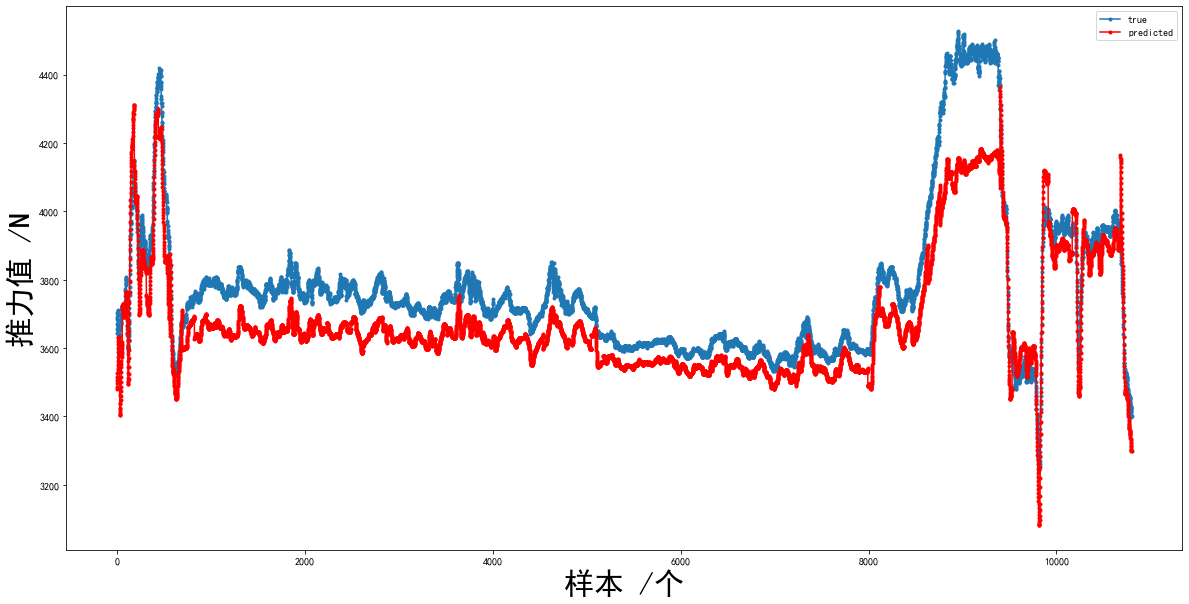

In [46]:
plt.figure(figsize=(20,10))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.xlabel('样本 /个',fontdict={ 'size'   : 30})
plt.ylabel('推力值 /N',fontdict={ 'size'   : 30})
plt.plot(trainY_1[200:11000],marker='.',label='true')
plt.plot((predictions*19043.454262518393+23.9856747376088)[200:11000],'r',marker='.',label='predicted')                  #sample的时刻是一致的
plt.legend(); 